In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import stan  # pystan
from scipy.stats import mstats  # 単回帰.ipynbでは、未使用
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/real_estate1.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      23 non-null     int64 
 1   space   23 non-null     int64 
 2   room    23 non-null     object
 3   value   23 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 864.0+ bytes


信頼区間：精度  
予測区間：モデルにより取りうる範囲  
generated quantities：発生させるサンプルを定義するブロック

In [5]:
stan_model = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_s;
  real X_s[N_s];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N){
    Y[n] ~ normal(a * X[n] + b, sigma);
  }
}

generated quantities {
  real Y_s[N_s];
  for (n in 1:N_s){
    Y_s[n] = normal_rng(a * X_s[n] + b, sigma);
  }
}

"""

In [6]:
X_s = np.arange(40,90,1)  # 予測区間
N_s = X_s.shape[0]
stan_data = {"N":df.shape[0],
             "X":df["space"].values,
             "Y":df["value"].values,
             "N_s":N_s,
             "X_s":X_s}

In [4]:
# sm = pystan.StanModel(model_code=stan_model)

In [5]:
# fit = sm.sampling(data = stan_data, iter = 2000, warmup= 500, chains= 3, seed=123)

In [7]:
import nest_asyncio
nest_asyncio.apply()

In [8]:
posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.sample(num_chains=3, num_samples=1500, num_warmup=500, save_warmup=0)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_4_cjdjqn/model_yij7vjei.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_4_cjdjqn/model_yij7vjei.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_4_cjdjqn/model_yij7vjei.stan', line 7, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [9]:
# fit.extract("a")  # MCMCでサンプリング取得した"a"の値をarrayで取得

OrderedDict([('a',
              array([ 76.41266253,  93.94065493,  80.63040866, ...,  95.98200868,
                      53.71508784, 105.92215028]))])

In [9]:
fit['a']

array([[56.69073092, 90.44231973, 81.10238358, ..., 84.09344139,
        67.06041348, 74.04121167]])

In [15]:
# fit.extract()

OrderedDict([('a',
              array([ 76.41266253,  93.94065493,  80.63040866, ...,  95.98200868,
                      53.71508784, 105.92215028])),
             ('b',
              array([ -561.55496799, -1909.86642069, -1074.95954857, ...,
                     -1709.27413073,   967.83287616, -2906.2669466 ])),
             ('sigma',
              array([619.90458227, 617.69534307, 464.08057631, ..., 606.19650203,
                     864.23714251, 653.98174108])),
             ('Y_s',
              array([[2294.27605834, 3514.28858887, 2488.67046828, ..., 6417.71304102,
                      5567.66601253, 5241.66336519],
                     [2041.32586214, 2063.52099482, 2431.06705493, ..., 7223.87892607,
                      5739.2849962 , 6356.12569545],
                     [2051.87128719, 1638.31423125, 2882.93646296, ..., 6029.77266042,
                      6102.38628348, 5869.81921034],
                     ...,
                     [1435.28210063, 1497.00088542, 2568.1

In [10]:
df_fit = fit.to_frame()
df_fit.describe().T.head(12)

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4500.0,-152.030912,1.352336,-161.098055,-152.622647,-151.669867,-151.057271,-150.399713
accept_stat__,4500.0,0.937292,0.094173,0.211363,0.918100,0.976521,0.995761,1.000000
stepsize__,4500.0,0.099721,0.011330,0.084447,0.084447,0.103169,0.111546,0.111546
treedepth__,4500.0,3.878444,1.141715,1.000000,3.000000,4.000000,5.000000,6.000000
n_leapfrog__,4500.0,24.200889,15.120634,1.000000,11.000000,27.000000,31.000000,63.000000
divergent__,4500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,4500.0,153.535246,1.830289,150.479048,152.192754,153.202700,154.471976,164.783049
a,4500.0,78.011772,11.826170,26.832259,70.422129,78.353572,85.401656,129.710558
b,4500.0,-696.594315,849.365219,-4299.020429,-1216.884306,-715.860927,-151.728624,2856.403828


In [ ]:
# ms_a = fit.extract("a")["a"]  # サンプルを受け取る

In [17]:
# ms_a

array([ 76.41266253,  93.94065493,  80.63040866, ...,  95.98200868,
        53.71508784, 105.92215028])

In [11]:
ms_a = df_fit["a"]

ms_a.values

array([56.69073092, 90.44231973, 81.10238358, ..., 84.09344139,
       67.06041348, 74.04121167])

(array([   4.,   34.,  165.,  643., 1387., 1474.,  618.,  150.,   21.,
           4.]),
 array([ 26.83225873,  37.12008863,  47.40791853,  57.69574843,
         67.98357833,  78.27140824,  88.55923814,  98.84706804,
        109.13489794, 119.42272784, 129.71055774]),
 <BarContainer object of 10 artists>)

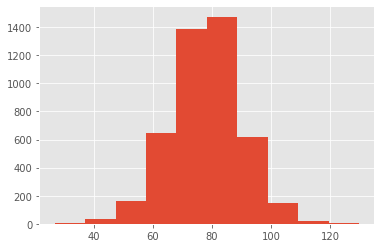

In [12]:
plt.hist(ms_a)  # 事後分布（の再現）

In [13]:
# ms_b = fit.extract("b")["b"]

ms_b = df_fit["b"]

In [14]:
df_b = pd.DataFrame([])  # 4,500のサンプル（信頼区間）格納
for i in range(40, 90, 1):
    df_b[i] = ms_a * i + ms_b

In [15]:
df_b

,40,41,42,43,44,45,46,47,48,49,...,80,81,82,83,84,85,86,87,88,89
draws,,,,,,,,,,,,,,,,,,,,,
0,3155.463772,3212.154503,3268.845234,3325.535965,3382.226696,3438.917427,3495.608158,3552.298889,3608.989620,3665.680351,...,5423.093009,5479.783740,5536.474471,5593.165202,5649.855933,5706.546664,5763.237395,5819.928126,5876.618857,5933.309588
1,1988.085226,2078.527546,2168.969866,2259.412186,2349.854505,2440.296825,2530.739145,2621.181465,2711.623784,2802.066104,...,5605.778016,5696.220335,5786.662655,5877.104975,5967.547295,6057.989614,6148.431934,6238.874254,6329.316574,6419.758893
2,2243.910756,2325.013139,2406.115523,2487.217906,2568.320290,2649.422674,2730.525057,2811.627441,2892.729824,2973.832208,...,5488.006099,5569.108483,5650.210866,5731.313250,5812.415633,5893.518017,5974.620400,6055.722784,6136.825168,6217.927551
3,3122.210388,3178.431646,3234.652903,3290.874160,3347.095417,3403.316674,3459.537931,3515.759188,3571.980445,3628.201703,...,5371.060674,5427.281931,5483.503188,5539.724445,5595.945702,5652.166959,5708.388216,5764.609474,5820.830731,5877.051988
4,2485.964743,2562.541096,2639.117448,2715.693801,2792.270153,2868.846506,2945.422858,3021.999211,3098.575563,3175.151916,...,5549.018844,5625.595197,5702.171549,5778.747902,5855.324254,5931.900607,6008.476959,6085.053312,6161.629664,6238.206017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,2747.280651,2813.861454,2880.442256,2947.023058,3013.603860,3080.184662,3146.765464,3213.346266,3279.927068,3346.507870,...,5410.512735,5477.093538,5543.674340,5610.255142,5676.835944,5743.416746,5809.997548,5876.578350,5943.159152,6009.739954
4496,2241.704646,2326.053283,2410.401919,2494.750556,2579.099193,2663.447830,2747.796467,2832.145103,2916.493740,3000.842377,...,5615.650118,5699.998755,5784.347391,5868.696028,5953.044665,6037.393302,6121.741939,6206.090575,6290.439212,6374.787849
4497,2076.877425,2160.970866,2245.064308,2329.157749,2413.251191,2497.344632,2581.438073,2665.531515,2749.624956,2833.718398,...,5440.615081,5524.708522,5608.801964,5692.895405,5776.988846,5861.082288,5945.175729,6029.269170,6113.362612,6197.456053


下限値と上限値をもとめる　$mstats.mquantiles$  
　50%信頼区間→0.25-0.75  
　95%信頼区間→0.025-0.975

In [16]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25,0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025,0.975], axis=0)

In [17]:
fit["a"].mean()

78.0117715659362

In [18]:
fit["b"].mean()

-696.5943152081593

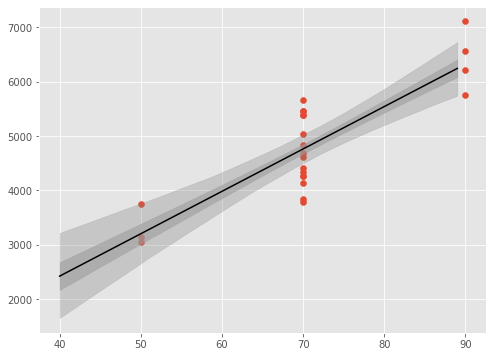

In [19]:
plt.figure(figsize=(8,6))

plt.scatter(df["space"],df["value"])

plt.fill_between(X_s, low_y50, high_y50, alpha=0.6, color="darkgray")  # alpha:透明度
plt.fill_between(X_s, low_y95, high_y95, alpha=0.3, color="gray")

a = 78.01
b = -696.59
y = a * X_s + b
plt.plot(X_s, y, color ="black");

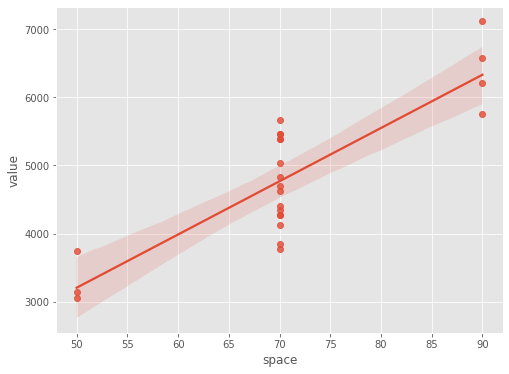

In [20]:
plt.figure(figsize=(8,6))
import seaborn as sns
sns.regplot(x=df["space"], y=df["value"]);

## 予測区間

In [21]:
# Y_p = fit.extract("Y_s")["Y_s"]  # generated quantities で予測した値

Y_p = fit["Y_s"].T

In [22]:
low_y, high_y = mstats.mquantiles(Y_p, [0.025,0.975], axis=0)  # バラつく可能性のある区間（95%信頼区間として）

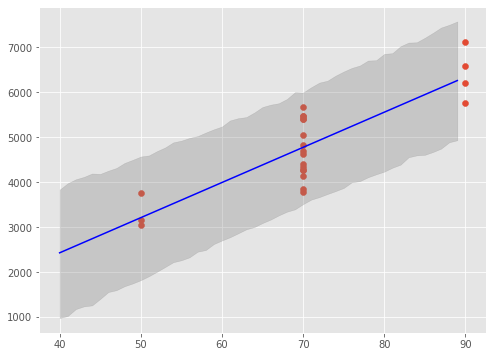

In [23]:
plt.figure(figsize=(8,6))

plt.scatter(df["space"],df["value"])
plt.fill_between(X_s, low_y, high_y, alpha=0.3, color="gray")

# a = 77.66
# b = -670.7
a = 78.17
b = -701.72
y = a * X_s + b
plt.plot(X_s, y, color ="blue");